In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.decomposition import PCA

In [20]:
with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

with open("X.pkl", "rb") as f:
    X = pickle.load(f)

with open("y.pkl", "rb") as f:
    y = pickle.load(f)

with open("rf_scoresFullX.pk", "rb") as f:
    rf_scoresFullX = pickle.load(f)

In [27]:
mi_scores = mutual_info_classif(X_train,y_train)
mi_scores = pd.Series(mi_scores, index = X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores[:5]

pdays               0.068256
poutcome_success    0.043549
month_mar           0.040237
poutcome_unknown    0.036578
job_entrepreneur    0.030435
dtype: float64

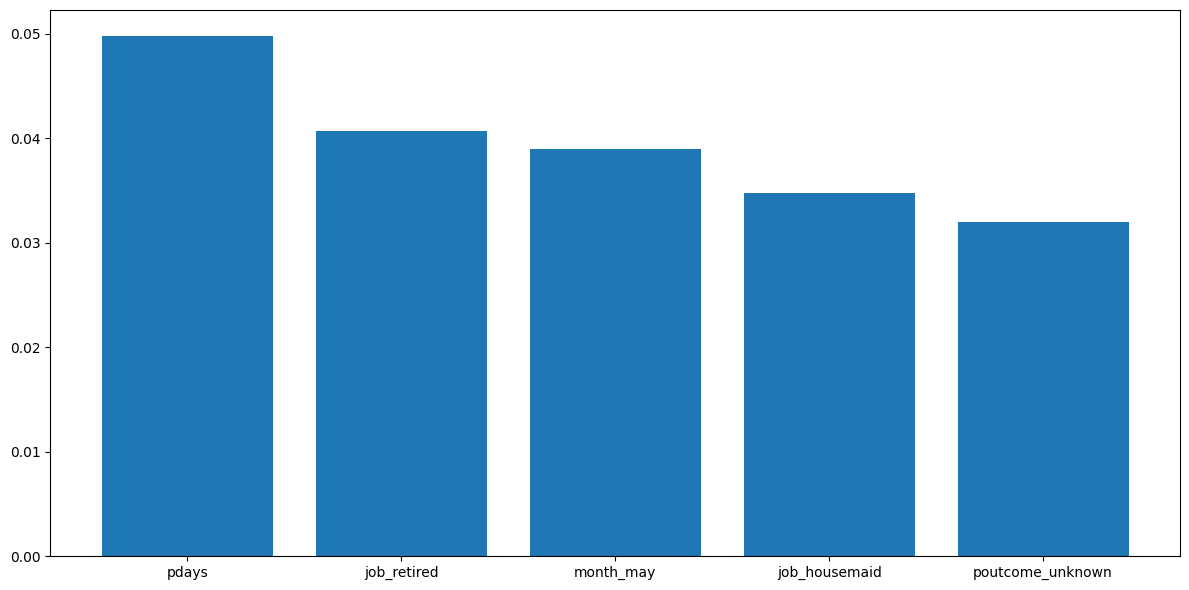

In [11]:
plt.figure(figsize=(12,6))
plt.bar(mi_scores[:5].index, mi_scores[:5].values)
plt.tight_layout()
plt.show()

In [12]:
X_train = X_train[mi_scores[:5].index]
X_test = X_test[mi_scores[:5].index]

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=57)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(rf_model.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp
print(rf_model.score(X_test, y_test))

0.5885167464114832
[[83 21]
 [65 40]]
              precision    recall  f1-score   support

           0       0.56      0.80      0.66       104
           1       0.66      0.38      0.48       105

    accuracy                           0.59       209
   macro avg       0.61      0.59      0.57       209
weighted avg       0.61      0.59      0.57       209

0.5885167464114832


In [16]:
pipeline = Pipeline([
    ("feature_selection", SelectKBest(score_func=mutual_info_classif, k=5)),
    ("rf", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=57))
])

In [18]:
rf_scores = cross_validate(pipeline, X, y, cv=10, return_train_score=True)
rf_train_scores = rf_scores['train_score']
rf_test_scores = rf_scores['test_score']

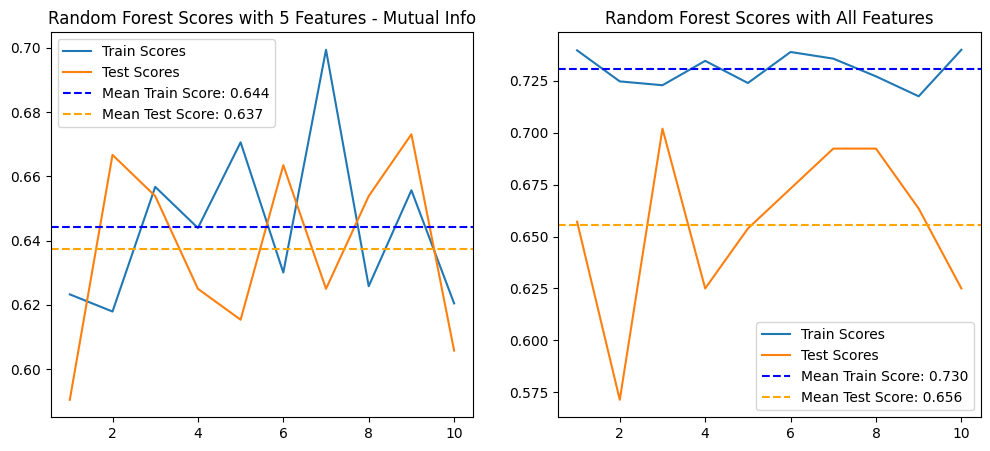

In [33]:
plt.figure(figsize=(12,5))  

plt.subplot(1,2,1)
plt.plot(range(1,11), rf_train_scores, label = "Train Scores")  
plt.plot(range(1,11), rf_test_scores, label="Test Scores")
plt.axhline(np.mean(rf_train_scores), color='blue', linestyle='--', label=f'Mean Train Score: {np.mean(rf_train_scores):.3f}')  
plt.axhline(np.mean(rf_test_scores), color='orange', linestyle='--', label=f'Mean Test Score: {np.mean(rf_test_scores):.3f}')  

plt.title("Random Forest Scores with 5 Features - Mutual Info")  
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1,11), rf_scoresFullX["train_score"], label="Train Scores")
plt.plot(range(1,11), rf_scoresFullX["test_score"], label="Test Scores")
plt.axhline(np.mean(rf_scoresFullX["train_score"]), color='blue', linestyle='--', label=f'Mean Train Score: {np.mean(rf_scoresFullX["train_score"]):.3f}')  
plt.axhline(np.mean(rf_scoresFullX["test_score"]), color='orange', linestyle='--', label=f'Mean Test Score: {np.mean(rf_scoresFullX["test_score"]):.3f}')  

plt.title("Random Forest Scores with All Features")  
plt.legend()

plt.show()

balance      0.165442
age          0.141402
day          0.127954
campaign     0.070355
education    0.039031
dtype: float64


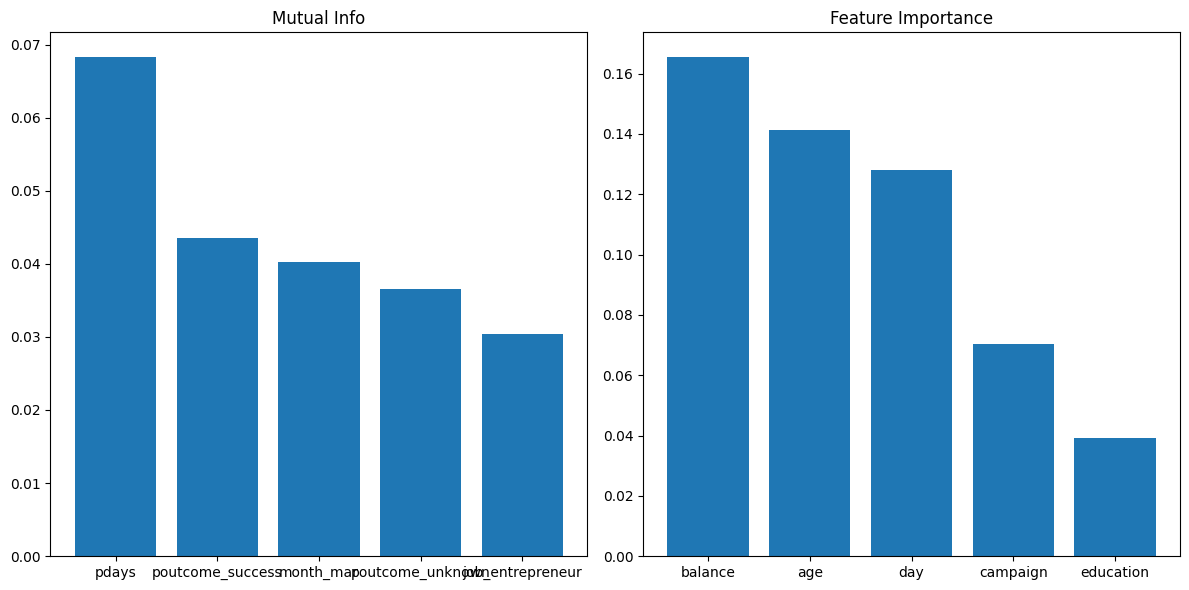

In [49]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=57)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)
print(feat_importances.sort_values(ascending=False).head(5))

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.bar(mi_scores[:5].index, mi_scores[:5].values)
plt.tight_layout()
plt.title("Mutual Info")


plt.subplot(1,2,2)
plt.bar(feat_importances.sort_values(ascending=False).head(5).index,  feat_importances.sort_values(ascending=False).head(5).values)
plt.tight_layout()
plt.title("Feature Importance")

plt.show()

In [31]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top5_features = importances.sort_values(ascending=False).head(5).index

X_selected = X[top5_features]

rf_model_selected = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=57)
rf_scores_selected = cross_validate(rf_model_selected, X_selected, y, cv=10, return_train_score=True)

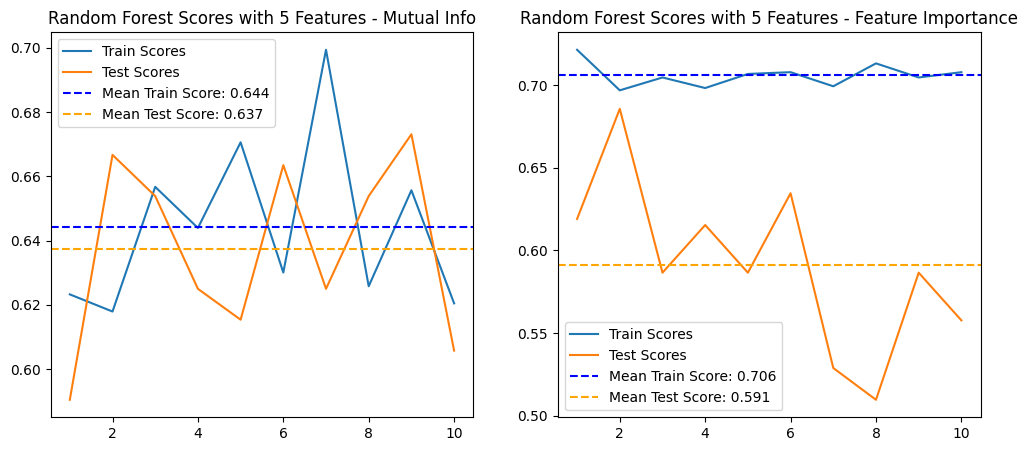

In [40]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,2)
plt.plot(range(1,11), rf_scores_selected["train_score"], label="Train Scores")
plt.plot(range(1,11), rf_scores_selected["test_score"], label="Test Scores")
plt.axhline(np.mean(rf_scores_selected["train_score"]), color='blue', linestyle='--', label=f'Mean Train Score: {np.mean(rf_scores_selected["train_score"]):.3f}')  
plt.axhline(np.mean(rf_scores_selected["test_score"]), color='orange', linestyle='--', label=f'Mean Test Score: {np.mean(rf_scores_selected["test_score"]):.3f}')  

plt.title("Random Forest Scores with 5 Features - Feature Importance")  
plt.legend()


plt.subplot(1,2,1)
plt.plot(range(1,11), rf_train_scores, label = "Train Scores")  
plt.plot(range(1,11), rf_test_scores, label="Test Scores")
plt.axhline(np.mean(rf_train_scores), color='blue', linestyle='--', label=f'Mean Train Score: {np.mean(rf_train_scores):.3f}')  
plt.axhline(np.mean(rf_test_scores), color='orange', linestyle='--', label=f'Mean Test Score: {np.mean(rf_test_scores):.3f}')  

plt.title("Random Forest Scores with 5 Features - Mutual Info")  
plt.legend()

In [37]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_variance_ratio)
print("Total:", explained_variance_ratio.sum())

Explained variance ratios: [9.98645566e-01 1.33140197e-03 1.43728549e-05 7.30294429e-06
 7.72775510e-07]
Total: 0.9999994168673524


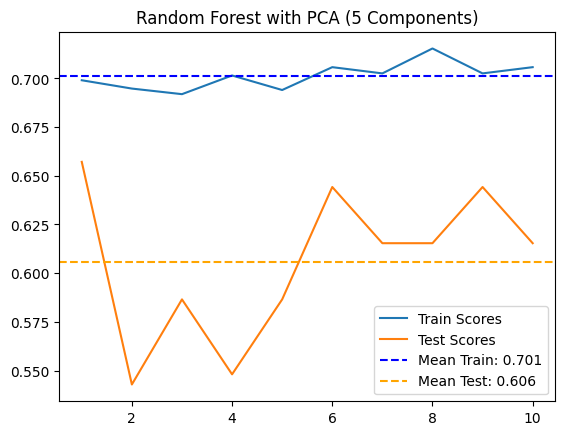

In [39]:
model_pca = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=57)
pca_scors = cross_validate(model_pca, X_pca, y, cv=10, return_train_score=True)

plt.plot(range(1, 11), pca_scors["train_score"], label="Train Scores")
plt.plot(range(1, 11), pca_scors["test_score"], label="Test Scores")
plt.axhline(np.mean(pca_scors["train_score"]), linestyle="--", color="blue", label=f"Mean Train: {np.mean(pca_scors['train_score']):.3f}")
plt.axhline(np.mean(pca_scors["test_score"]), linestyle="--", color="orange", label=f"Mean Test: {np.mean(pca_scors['test_score']):.3f}")
plt.title("Random Forest with PCA (5 Components)")
plt.legend()
plt.show()

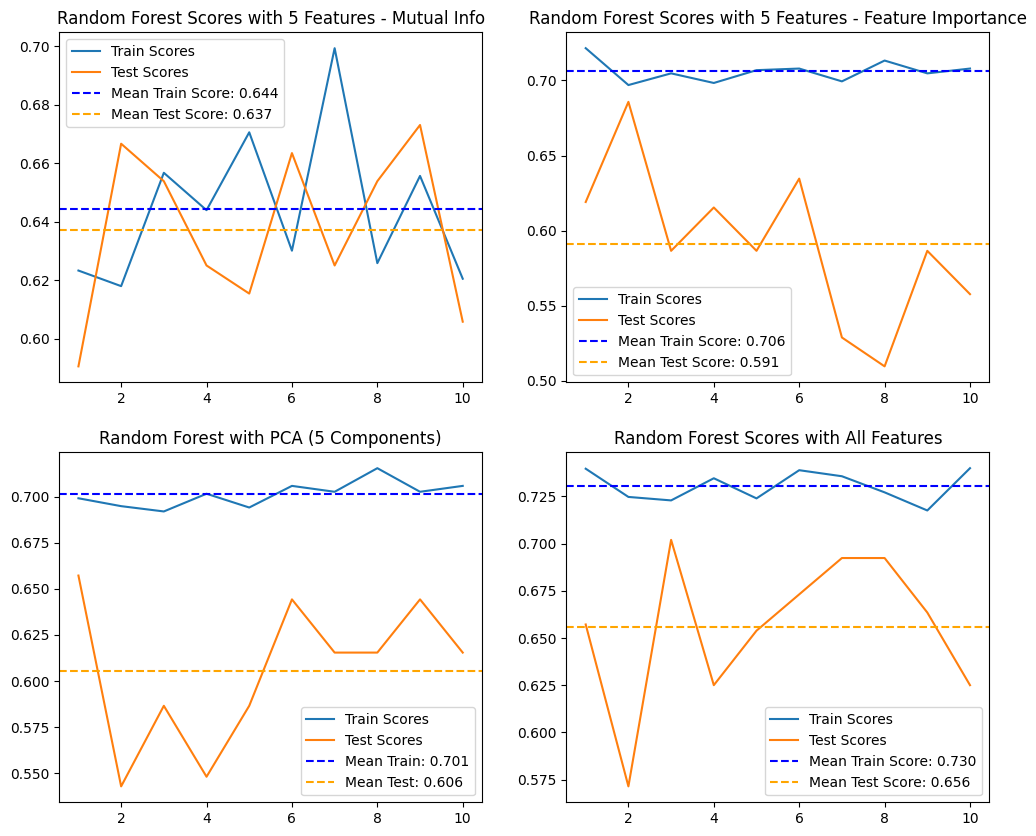

In [51]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(range(1,11), rf_train_scores, label = "Train Scores")  
plt.plot(range(1,11), rf_test_scores, label="Test Scores")
plt.axhline(np.mean(rf_train_scores), color='blue', linestyle='--', label=f'Mean Train Score: {np.mean(rf_train_scores):.3f}')  
plt.axhline(np.mean(rf_test_scores), color='orange', linestyle='--', label=f'Mean Test Score: {np.mean(rf_test_scores):.3f}')  

plt.title("Random Forest Scores with 5 Features - Mutual Info")  
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(1,11), rf_scores_selected["train_score"], label="Train Scores")
plt.plot(range(1,11), rf_scores_selected["test_score"], label="Test Scores")
plt.axhline(np.mean(rf_scores_selected["train_score"]), color='blue', linestyle='--', label=f'Mean Train Score: {np.mean(rf_scores_selected["train_score"]):.3f}')  
plt.axhline(np.mean(rf_scores_selected["test_score"]), color='orange', linestyle='--', label=f'Mean Test Score: {np.mean(rf_scores_selected["test_score"]):.3f}')  

plt.title("Random Forest Scores with 5 Features - Feature Importance")  
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(1, 11), pca_scors["train_score"], label="Train Scores")
plt.plot(range(1, 11), pca_scors["test_score"], label="Test Scores")
plt.axhline(np.mean(pca_scors["train_score"]), linestyle="--", color="blue", label=f"Mean Train: {np.mean(pca_scors['train_score']):.3f}")
plt.axhline(np.mean(pca_scors["test_score"]), linestyle="--", color="orange", label=f"Mean Test: {np.mean(pca_scors['test_score']):.3f}")
plt.title("Random Forest with PCA (5 Components)")
plt.legend()


plt.subplot(2,2,4)
plt.plot(range(1,11), rf_scoresFullX["train_score"], label="Train Scores")
plt.plot(range(1,11), rf_scoresFullX["test_score"], label="Test Scores")
plt.axhline(np.mean(rf_scoresFullX["train_score"]), color='blue', linestyle='--', label=f'Mean Train Score: {np.mean(rf_scoresFullX["train_score"]):.3f}')  
plt.axhline(np.mean(rf_scoresFullX["test_score"]), color='orange', linestyle='--', label=f'Mean Test Score: {np.mean(rf_scoresFullX["test_score"]):.3f}')  
plt.title("Random Forest Scores with All Features")  
plt.legend()
plt.show()



In [53]:
from scipy.stats import ttest_rel

scores_method1 = rf_scores_selected["test_score"]  
scores_method2 = pca_scors["test_score"]           

t_stat, p_value = ttest_rel(scores_method1, scores_method2)

print(f"T-istatistiği: {t_stat:.4f}")
print(f"P-değeri: {p_value:.4f}")

if p_value < 0.05:
    print("İstatistiksel olarak anlamlı bir fark var (p < 0.05)")
else:
    print("Anlamlı bir fark yok (p >= 0.05)")


print("\n\n")


scores_method1 = rf_scoresFullX["test_score"]  
scores_method2 = pca_scors["test_score"]  

t_stat, p_value = ttest_rel(scores_method1, scores_method2)

print(f"T-istatistiği: {t_stat:.4f}")
print(f"P-değeri: {p_value:.4f}")

if p_value < 0.05:
    print("İstatistiksel olarak anlamlı bir fark var (p < 0.05)")
else:
    print("Anlamlı bir fark yok (p >= 0.05)")

T-istatistiği: -0.6180
P-değeri: 0.5519
Anlamlı bir fark yok (p >= 0.05)



T-istatistiği: 4.2012
P-değeri: 0.0023
İstatistiksel olarak anlamlı bir fark var (p < 0.05)
